In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from joblib import dump
from flask import Flask, request, render_template
from joblib import load
import scipy.sparse as sp
import numpy as np

In [2]:
# Importing CSV files
fake_news = pd.read_csv('Fake.csv')
real_news = pd.read_csv('True.csv').sample(n=len(fake_news), replace=True, random_state=42)

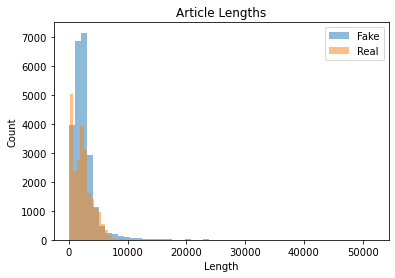

In [3]:
# Plotting article lengths
fake_lengths = fake_news['text'].apply(len)
real_lengths = real_news['text'].apply(len)
plt.hist(fake_lengths, bins=50, alpha=0.5, label='Fake')
plt.hist(real_lengths, bins=50, alpha=0.5, label='Real')
plt.title('Article Lengths')
plt.xlabel('Length')
plt.ylabel('Count')
plt.legend()
plt.show()

In [4]:
# Function to get most common words
def get_most_common_words(texts, num_words=10):
    all_words = []
    for text in texts:
        all_words.extend(nltk.word_tokenize(text.lower()))
    stop_words = set(nltk.corpus.stopwords.words('english'))
    words = [word for word in all_words if word.isalpha() and word not in stop_words]
    word_counts = Counter(words)
    return word_counts.most_common(num_words)

# Get most common words in real and fake news
fake_words = get_most_common_words(fake_news['text'])
real_words = get_most_common_words(real_news['text'])
print('Fake News:', fake_words)
print('Real News:', real_words)

Fake News: [('trump', 74240), ('said', 31149), ('people', 26012), ('president', 25770), ('would', 23461), ('one', 22994), ('clinton', 18085), ('obama', 17920), ('like', 17660), ('donald', 17235)]
Real News: [('said', 108291), ('trump', 59266), ('would', 34666), ('reuters', 31136), ('president', 28775), ('state', 21415), ('government', 20378), ('new', 18244), ('house', 18130), ('states', 18114)]


In [5]:
# Preprocessing text
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuation and digits
    text = text.translate(str.maketrans('', '', string.punctuation + string.digits))
    # Tokenize the text
    words = word_tokenize(text)
    # Remove stop words
    words = [word for word in words if word not in stop_words]
    # Stem or lemmatize the words
    words = [stemmer.stem(word) for word in words]
    # Join the words back into a string
    text = ' '.join(words)
    return text

# Applying preprocessing to fake and real news
fake_news['text'] = fake_news['text'].apply(preprocess_text)
real_news['text'] = real_news['text'].apply(preprocess_text)

[nltk_data] Downloading package wordnet to C:\Users\Ashfakur
[nltk_data]     Rahman\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
# Creating feature matrix and labels
vectorizer = CountVectorizer()
X_fake = vectorizer.fit_transform(fake_news['text'])
X_real = vectorizer.transform(real_news['text'])
X = sp.vstack([X_fake, X_real])
y = np.concatenate([np.zeros(X_fake.shape[0]), np.ones(X_real.shape[0])])

In [7]:
# Splitting data into training and testing sets (maintaining class distribution)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Training and evaluating a Multinomial Naive Bayes model
print("Training and evaluating Multinomial Naive Bayes model...")
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

Training and evaluating Multinomial Naive Bayes model...


In [8]:
# Print evaluation metrics for Multinomial Naive Bayes for Training
print('Accuracy:', accuracy_score(y_test, y_pred_nb))
print('Precision:', precision_score(y_test, y_pred_nb))
print('Recall:', recall_score(y_test, y_pred_nb))
print('F1 Score:', f1_score(y_test, y_pred_nb))
print()

Accuracy: 0.9350580219312253
Precision: 0.9132281553398058
Recall: 0.9614565587734242
F1 Score: 0.9367219917012447



In [9]:
# Training and evaluating a Support Vector Machine model
print("Training and evaluating Support Vector Machine model...")
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

Training and evaluating Support Vector Machine model...


In [10]:
# Print evaluation metrics for Support Vector Machine for testing
print('Accuracy:', accuracy_score(y_test, y_pred_svm))
print('Precision:', precision_score(y_test, y_pred_svm))
print('Recall:', recall_score(y_test, y_pred_svm))
print('F1 Score:', f1_score(y_test, y_pred_svm))

Accuracy: 0.996167358671351
Precision: 0.9955338153977031
Recall: 0.9968057921635435
F1 Score: 0.996169397744201


In [11]:
# Dumping the model and vectorizer to files
dump(nb, 'model_nb.joblib')
dump(svm, 'model_svm.joblib')
dump(vectorizer, 'vectorizer.joblib')

['vectorizer.joblib']